## Data and objective

###Objective

Predict adult female (18+) anemia status in the US.



###Target vector: Anemia

'According to the World Health Organization (WHO), anemia is defined as `hemoglobin (Hb)` levels `<12.0 g/dL` in women and `<13.0 g/dL` in men.

Source: https://www.sciencedirect.com/science/article/abs/pii/S0037196315000621 

###Features (independent variables):

age, height, weight, education, race, family income to poverty ratio,dominant hand, arm circumference, arm lenghth in cm,	leg length in cm,  waist circumference	

### Data

National Health and Nutrition Examination Survey (NHANES) 2013-2014

source: https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2013

In [ ]:
%%capture

!pip install category_encoders==2.*
!pip install pandas_profiling==2.*

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, validation_curve # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
directory=pd.read_csv('/content/females.csv')

pd.set_option('display.max_columns', None)
print(directory.shape)

directory.head(2)

**ProfileReport**

In [ ]:
from pandas_profiling import ProfileReport

report = ProfileReport(directory, minimal=True).to_notebook_iframe()
report

**Data Wrangling**

In [ ]:
def wrangle(me):
  df=pd.read_csv(me, index_col='id').sort_index()
  df.drop(['Unnamed: 0'], axis=1, inplace=True)

  # select only demographic features:
  df=df[['age','race','education','pregnancy','inc_poverty_ratio',
  #'hr_60sec','pulse_60sec','pulse_regularity','pulse_type','systol1','diastol1','systol2',
  #'diastol2','systol3','diastol3','systol4','diastol4',
  'weight','head_circum','height',
  'leg_cm','arm_cm','arm_circum','waist_circum','pregnant_or_breastfeeding','dominant_hand','hemoglobin']]
  # filter observations with age>18 years of age
  df = df[df['age'] >=18] 

  # drop columns with NaN values (>50%)
  df.dropna(axis=1, thresh=2431, inplace = True)

  # # create a new feature for mean of systolic and then drop sys1, sys2, sys3
  # df['systolic_bp'] = (df['systol1'] + df['systol2'] + df['systol3'])/3
  # df.drop(columns= ['systol1','systol2','systol3'], inplace=True)
  # # create new feature for mean of diastolic and then drop dias1, dias2, dias3
  # df['diastolic_bp'] = (df['diastol1']+df['diastol2']+df['diastol3'])/3
  # df.drop(columns= ['diastol1','diastol2','diastol3'], inplace=True)
  # # Create the target variable (anemia) from 'hemoglobing' level in blood

  # create target vector (anemia), and drop 'hemoglobin'
  df.loc[(df['hemoglobin'] <12), 'anemia'] = 1
  df.loc[(df['hemoglobin'] >=12), 'anemia'] = 0
  df.drop(columns= ['hemoglobin'], inplace=True)
  # change dtype:
  # df[['anemia']] = df['anemia'].astype(int)
  # df[['education']] = df['education'].astype(int)
  # df[['dominant_hand']] = df['dominant_hand'].astype(int)
  # drop any row with a missing value
  df.dropna(axis=0, how='any', inplace=True)

  # sort column by their names
  df = df.reindex(sorted(df.columns), axis=1)

  return df

df_f = wrangle('/content/females.csv')


In [ ]:
print(df_f.shape)
df_f.head()

(2281, 12)


,age,anemia,arm_circum,arm_cm,dominant_hand,education,height,inc_poverty_ratio,leg_cm,race,waist_circum,weight
id,,,,,,,,,,,,
73564,61,0.0,38.0,39.3,1.0,5.0,161.8,5.00,37.1,3,110.8,93.4
73566,56,0.0,29.0,33.5,2.0,3.0,152.8,0.48,32.4,3,85.5,61.8
73568,26,0.0,25.8,32.6,1.0,5.0,152.5,5.00,34.4,3,73.7,47.1
73574,33,1.0,26.5,33.4,1.0,5.0,158.0,2.10,37.5,6,78.7,56.8
73596,57,0.0,37.2,37.6,1.0,5.0,164.7,5.00,35.3,6,117.8,104.0


In [ ]:
# df_f['age'].describe()

In [ ]:
target = 'anemia'
X = df_f.drop(columns=target)
y=df_f[target]

df_f.shape, X.shape, y.shape

((2281, 12), (2281, 11), (2281,))

In [ ]:
X.head()

,age,arm_circum,arm_cm,dominant_hand,education,height,inc_poverty_ratio,leg_cm,race,waist_circum,weight
id,,,,,,,,,,,
73564,61,38.0,39.3,1.0,5.0,161.8,5.00,37.1,3,110.8,93.4
73566,56,29.0,33.5,2.0,3.0,152.8,0.48,32.4,3,85.5,61.8
73568,26,25.8,32.6,1.0,5.0,152.5,5.00,34.4,3,73.7,47.1
73574,33,26.5,33.4,1.0,5.0,158.0,2.10,37.5,6,78.7,56.8
73596,57,37.2,37.6,1.0,5.0,164.7,5.00,35.3,6,117.8,104.0


In [ ]:
y.value_counts()

0.0    1992
1.0     289
Name: anemia, dtype: int64

In [ ]:
#Train_ and Test split 
X_train_, X_test, y_train_, y_test = train_test_split(X, y , test_size=0.2)

In [ ]:
#SMOTE
# import library
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE()

# fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X_train_, y_train_)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0.0: 1992, 1.0: 289})
Resample dataset shape Counter({0.0: 1599, 1.0: 1599})


In [ ]:
#SMOTE

# Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.25)

In [ ]:
X_train.shape, y_train.shape, X_val.shape,y_val.shape

((2398, 11), (2398,), (800, 11), (800,))

In [ ]:
print('baseline accuracy:', y_train.value_counts(normalize=True).max())

baseline accuracy: 0.505838198498749


In [ ]:
model_randomf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

model_randomf.fit(X_train, y_train);

In [ ]:
print('FOREST: Training Accuracy:',model_randomf.score(X_train, y_train))
print('FOREST: Validation Accuracy:',model_randomf.score(X_val, y_val))
print('FOREST: Test Accuracy:',model_randomf.score(X_test, y_test))

FOREST: Training Accuracy: 1.0
FOREST: Validation Accuracy: 0.93375
FOREST: Test Accuracy: 0.8468271334792122


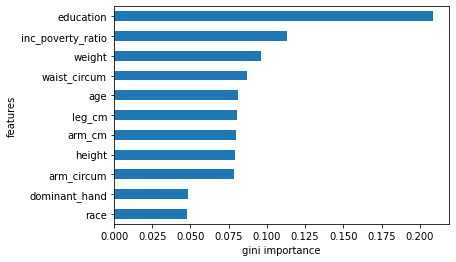

In [ ]:
# What are the most important features? 
features = model_randomf.named_steps['ordinalencoder'].get_feature_names()
gini = model_randomf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(11).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

In [ ]:
cv_scores_rf = cross_val_score(model_randomf, X, y, cv=10,n_jobs=-1)

In [ ]:
print('CV score RandomForestClassifier')
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
Mean CV accuracy score: 0.8719853673485023
STD CV accuracy score: 0.0038399337934217


In [ ]:
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__max_depth': range(50, 100, 50),
    'randomforestclassifier__max_features': range(5, 11, 1),
    'randomforestclassifier__n_estimators': range(100, 300, 50)
}

model_rfgrid = GridSearchCV(
    clf,
    param_grid = param_grid,
    n_jobs=-1,
    cv=None,
    verbose=1 # status updates
)

model_rfgrid.fit(X, y)

In [ ]:
model_rfgrid.best_estimator_ 

Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=50, max_features=5,
                                        n_estimators=250, n_jobs=-1,
                                        random_state=42))])

In [ ]:
model_rf_tuned = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(
        max_depth=50,max_features=5 ,n_estimators=140,
        random_state=42, n_jobs=-1)
)

model_rf_tuned.fit(X_train, y_train);

In [ ]:
print('Training Accuracy:',model_rf_tuned.score(X_train, y_train))
print('Validation Accuracy:',model_rf_tuned.score(X_val, y_val))
print('Test Accuracy:',model_rf_tuned.score(X_test, y_test))

Training Accuracy: 1.0
Validation Accuracy: 0.93625
Test Accuracy: 0.8533916849015317


In [ ]:
bestimator = model_rfgrid.best_estimator_
importances = bestimator.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(11).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


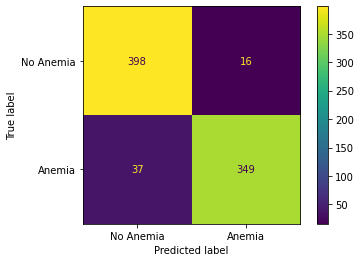

In [ ]:

from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(
    model_randomf,
    X_val, # validation data
    y_val, # validation data
    values_format ='.0f',
    display_labels = ['No Anemia', 'Anemia']
);

In [ ]:
print(classification_report(y_val,
                      model_randomf.predict(X_val),
                      target_names=['no anemia', 'anemia']))

              precision    recall  f1-score   support

   no anemia       0.95      0.97      0.96       423
      anemia       0.97      0.95      0.96       400

    accuracy                           0.96       823
   macro avg       0.96      0.96      0.96       823
weighted avg       0.96      0.96      0.96       823



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


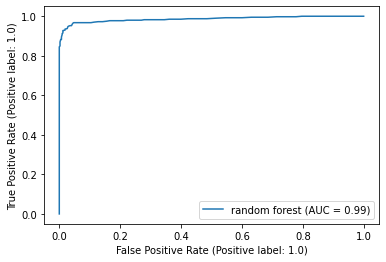

In [ ]:
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
rf = plot_roc_curve(
    model_randomf,
    X_val,
    y_val,
    name='random forest'
);

In [ ]:
roc_auc_score(y_val, model_randomf.predict_proba(X_val)[:,-1])

0.985913120567376

In [ ]:
# Get predicted probabilities from model

y_pred_prob = model_randomf.predict_proba(X_val)[:,-1]

# Input true labels and probability predictions 
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Put data into dictionary
data = {'false_pos_rate': fpr,
        'true_pos_rate': tpr,
        'thresholds':thresholds}

pd.options.display.max_rows=99
pd.DataFrame(data)

In [ ]:
#????? set the threshold in the model after retrieving it from ROC curve

In [ ]:
y_pred_prob[y_pred_prob>= 0.36] = 1
y_pred_prob[y_pred_prob < 0.36] = 0

In [ ]:
from sklearn.metrics import accuracy_score
print('Validation Accuracy (RF):', accuracy_score(y_val, y_pred_prob)) # accuracy goes up! 

Validation Accuracy (RF): 0.9210206561360875
